#### 1. datetime 데이터를 object가 아닌 datetime dtype으로 변환
- 시계열 데이터를 가공하기 더 쉽게하기위해

In [204]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('bike-sharing-demand/bike_train.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### 2. datetime 컬럼에서 년/월/일/시 를 쪼개서 새로운 컬럼 생성
#### 3. casual+registered = count 데이터이기 때문에 서로 상관도가 매우 높다. 따라서 casual, registered, datetime 컬럼 제거 

In [205]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [206]:
df['year'] = df['datetime'].apply(lambda x : x.year)
df['month'] = df['datetime'].apply(lambda x : x.month)
df['day'] = df['datetime'].apply(lambda x : x.day)
df['hour'] = df['datetime'].apply(lambda x : x.hour)
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [207]:
df.drop(['datetime','casual','registered'], axis=1, inplace=True)
df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


#### 4. rmsle, rmse, mae 성능평가를 위해 reg_eval 함수 생성

In [208]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))

def reg_eval(y, pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print(f'RMSLE : {rmsle_val : .3f}, RMSE : {rmse_val : .3f}, MAE : {mae_val : .3f}')

#### 오차가 어느정도인지 확인

In [209]:
X_data = df.drop('count',axis=1, inplace=False)
y_target = df['count']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target,
                                                   test_size=0.3,
                                                   random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
reg_eval(y_test, pred)

RMSLE :  1.165, RMSE :  140.900, MAE :  105.924


<ipython-input-208-b4cb6b836f1e>:5: RuntimeWarning: invalid value encountered in log1p
  log_pred = np.log1p(pred)


#### 5. RMSLE, RMSE 성능이 안좋게 나왔으므로 target 데이터를 log변환 한 후 학습
- 선형회귀에서는 feature, target값 모두 정규분포를 띄는 형태여야 성능이 향상된다

<AxesSubplot:>

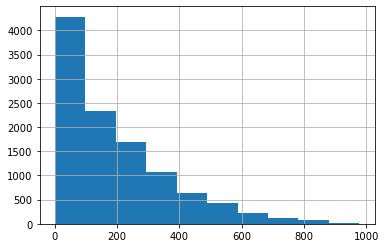

In [210]:
y_target.hist()

<AxesSubplot:>

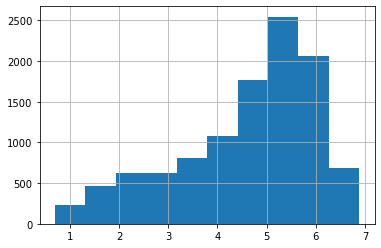

In [211]:
np.log1p(y_target).hist()

In [212]:
y_target_log = np.log1p(y_target)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target_log,
                                                    test_size=0.3,
                                                    random_state=0)
lr_reg= LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

reg_eval(y_test_exp, pred_exp)

RMSLE :  1.017, RMSE :  162.594, MAE :  109.286


#### 6. target값 log변환 후에도 큰 차이가 없기때문에 회귀계수 확인
- year가 상관관계가 가장높다는 일반적이지 않은 결과가 나옴
- classification과 다르게 선형회귀에서는 one-hot-encoding 필수임을 알수있음

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

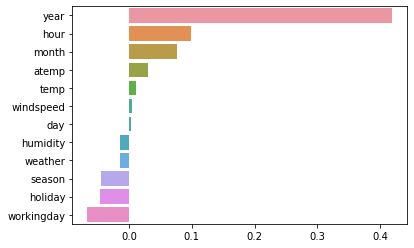

In [213]:
coef = pd.Series(lr_reg.coef_, index=X_data.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(coef_sort, coef_sort.index)

#### 7. 원핫 인코딩을 수행한 데이터로 성능평가

In [241]:
X_data_ohe = pd.get_dummies(X_data, columns=['month','hour','holiday','workingday','season','weather'])

X_train, X_test, y_train, y_test = train_test_split(X_data_ohe, y_target_log,
                                                   test_size=0.3,
                                                   random_state=0)
def get_model_eval(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('######', model.__class__.__name__, '######')
    reg_eval(y_test, pred)
    
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

models = [lr_reg, ridge_reg, lasso_reg]
for model in models:
    get_model_eval(model, X_train, X_test, y_train, y_test, is_expm1=True)

###### LinearRegression ######
RMSLE :  0.589, RMSE :  97.483, MAE :  63.106
###### Ridge ######
RMSLE :  0.590, RMSE :  98.417, MAE :  63.651
###### Lasso ######
RMSLE :  0.634, RMSE :  113.031, MAE :  72.658


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

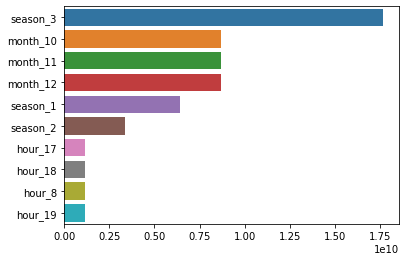

In [242]:
coef = pd.Series(lr_reg.coef_, index=X_data_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(coef_sort, coef_sort.index)

In [243]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=1000)
gbm_reg = GradientBoostingRegressor(n_estimators=1000)
lgbm_reg = LGBMRegressor(n_estimators=1000)

models = [rf_reg, gbm_reg, lgbm_reg]
for model in models:
    get_model_eval(model, X_train, X_test, y_train, y_test)

###### RandomForestRegressor ######
RMSLE :  0.093, RMSE :  0.353, MAE :  0.243
###### GradientBoostingRegressor ######
RMSLE :  0.088, RMSE :  0.329, MAE :  0.234
###### LGBMRegressor ######
RMSLE :  0.087, RMSE :  0.320, MAE :  0.222


### lgbm 모델로 kaggle submission
- bike sharing demand competition은 RMSLE점수를 기반으로 evaluation하기 때문에 RMSLE 점수가 가장 좋은 LGBM 선택
 - kaggle score : 0.41630 / ranking : about 400 (late submission)

In [244]:
submit = pd.read_csv('bike-sharing-demand/bike_test.csv')
submit['datetime'] = pd.to_datetime(submit['datetime'])
submit['year'] = submit['datetime'].apply(lambda x : x.year)
submit['month'] = submit['datetime'].apply(lambda x : x.month)
submit['day'] = submit['datetime'].apply(lambda x : x.day)
submit['hour'] = submit['datetime'].apply(lambda x : x.hour)
submit.drop('datetime',axis=1, inplace=True)
submit_ohe = pd.get_dummies(submit, columns=['month','hour','holiday','workingday','season','weather'])
count = lgbm_reg.predict(submit_ohe)
submit_final = pd.read_csv('bike-sharing-demand/bike_test.csv')
submit_final = submit_final.drop(['season','holiday','workingday','weather','temp','atemp','humidity','windspeed'], axis=1)
submit_final['count'] = np.round(np.expm1(count)).astype(int)
submit_final.to_csv('bike-sharing-demand/bike_submission.csv', index=False)